In [3]:
pip install statsmodels


   ---------------------------------------- 0.0/9.9 MB ? eta -:--:--
    --------------------------------------- 0.1/9.9 MB 2.8 MB/s eta 0:00:04
   - -------------------------------------- 0.4/9.9 MB 4.1 MB/s eta 0:00:03
   --- ------------------------------------ 0.8/9.9 MB 5.3 MB/s eta 0:00:02
   ---- ----------------------------------- 1.1/9.9 MB 5.7 MB/s eta 0:00:02
   ----- ---------------------------------- 1.3/9.9 MB 5.0 MB/s eta 0:00:02
   ----- ---------------------------------- 1.4/9.9 MB 5.1 MB/s eta 0:00:02
   ------ --------------------------------- 1.6/9.9 MB 4.9 MB/s eta 0:00:02
   ------- -------------------------------- 1.8/9.9 MB 4.8 MB/s eta 0:00:02
   -------- ------------------------------- 2.0/9.9 MB 4.7 MB/s eta 0:00:02
   -------- ------------------------------- 2.2/9.9 MB 4.6 MB/s eta 0:00:02
   --------- ------------------------------ 2.3/9.9 MB 4.5 MB/s eta 0:00:02
   --------- ------------------------------ 2.4/9.9 MB 4.3 MB/s eta 0:00:02
   ---------- ----


[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import numpy as np
import pandas as pd
# from plotnine import *
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_validate
from scipy.stats import boxcox, shapiro, probplot
from scipy.cluster.hierarchy import dendrogram, linkage
import statsmodels.api as sm
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

## Data Preprocessing

In [7]:
df=pd.read_csv("Wholesale customers data.csv")

In [8]:
df.head()

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,2,3,12669,9656,7561,214,2674,1338
1,2,3,7057,9810,9568,1762,3293,1776
2,2,3,6353,8808,7684,2405,3516,7844
3,1,3,13265,1196,4221,6404,507,1788
4,2,3,22615,5410,7198,3915,1777,5185


In [9]:
#Checking for nulls

df.isnull().sum()

Channel             0
Region              0
Fresh               0
Milk                0
Grocery             0
Frozen              0
Detergents_Paper    0
Delicassen          0
dtype: int64

In [10]:
#No nulls -great

#Checking for data types

df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440 entries, 0 to 439
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype
---  ------            --------------  -----
 0   Channel           440 non-null    int64
 1   Region            440 non-null    int64
 2   Fresh             440 non-null    int64
 3   Milk              440 non-null    int64
 4   Grocery           440 non-null    int64
 5   Frozen            440 non-null    int64
 6   Detergents_Paper  440 non-null    int64
 7   Delicassen        440 non-null    int64
dtypes: int64(8)
memory usage: 27.6 KB


In [11]:
#Statistical summary

df.describe()

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
count,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000
mean,1.322727,2.543182,12000.297727,5796.265909,7951.277273,3071.931818,2881.493182,1524.870455
std,0.468052,0.774272,12647.328865,7380.377175,9503.162829,4854.673333,4767.854448,2820.105937
min,1.000000,1.000000,3.000000,55.000000,3.000000,25.000000,3.000000,3.000000
25%,1.000000,2.000000,3127.750000,1533.000000,2153.000000,742.250000,256.750000,408.250000
50%,1.000000,3.000000,8504.000000,3627.000000,4755.500000,1526.000000,816.500000,965.500000
75%,2.000000,3.000000,16933.750000,7190.250000,10655.750000,3554.250000,3922.000000,1820.250000
max,2.000000,3.000000,112151.000000,73498.000000,92780.000000,60869.000000,40827.000000,47943.000000


In [12]:
#Let´s convert the categorical variables to meaningful data

df.Region.value_counts()

Region
3    316
1     77
2     47
Name: count, dtype: int64

In [13]:
df.Region=df.Region.map({3:'Other',2:'Lisbon',1:'Oporto'})

In [14]:
df.Channel.value_counts()

Channel
1    298
2    142
Name: count, dtype: int64

In [15]:
df.Channel=df.Channel.map({1:'Horeca',2:'Retail'})

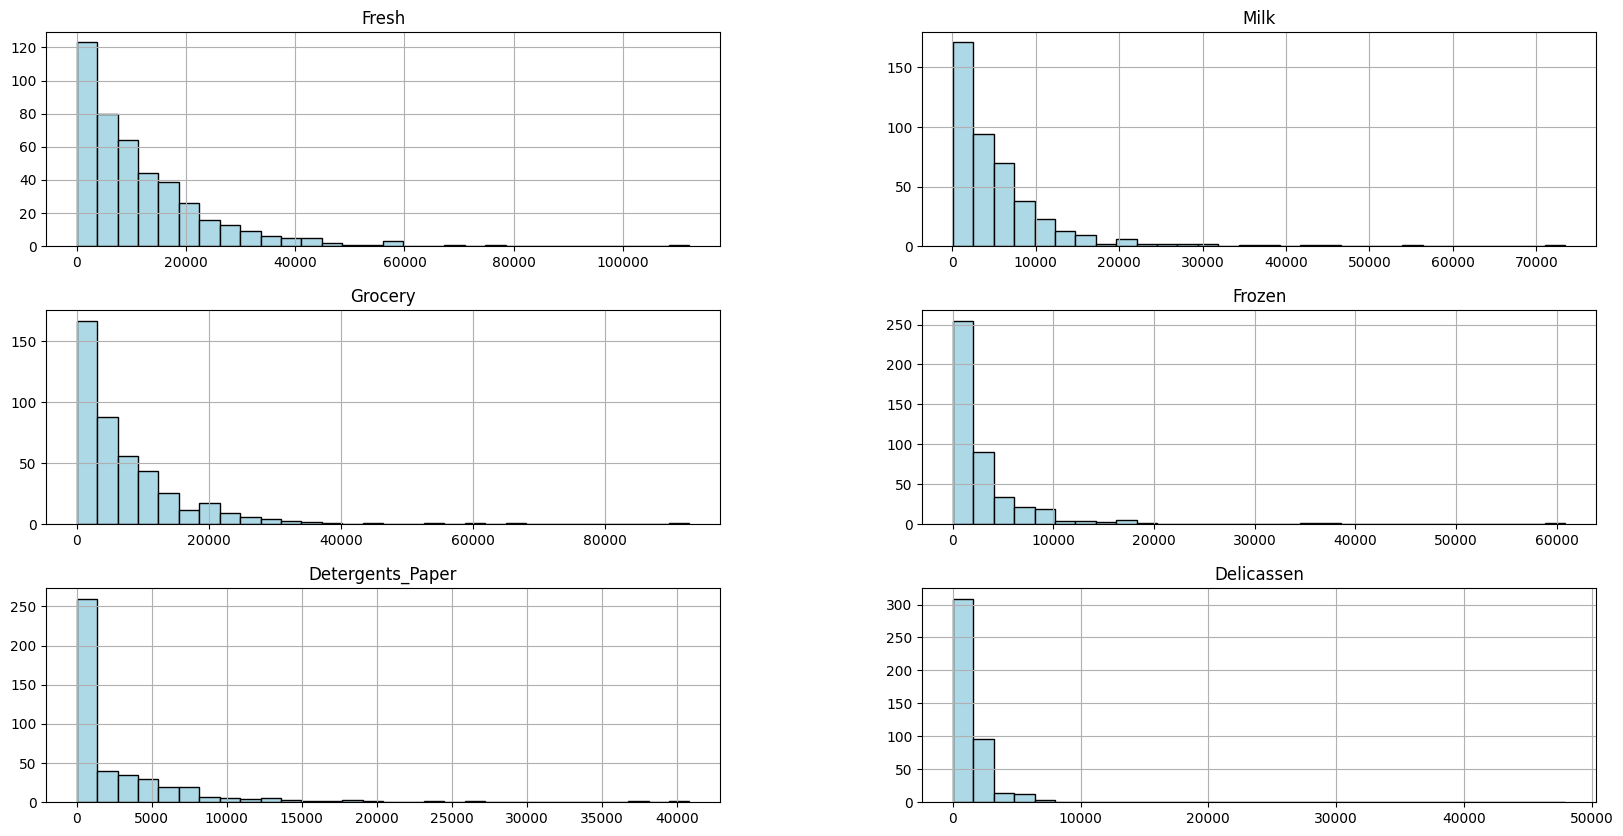

In [16]:
#Distribution of numeric variables

df.hist(figsize=(20,10),bins=30, color='lightblue', edgecolor='black')
plt.show()

In [17]:
data=df.copy()

lamb=[]
confidence=[]
for i in data.columns[2:]:
    data[i], coef, conf=boxcox(data[i]+0.0000001, alpha=0.05)   #We add a tiny constant as values need to be positive
                                                                #for Box-Cox
    lamb.append(coef)
    confidence.append(conf)

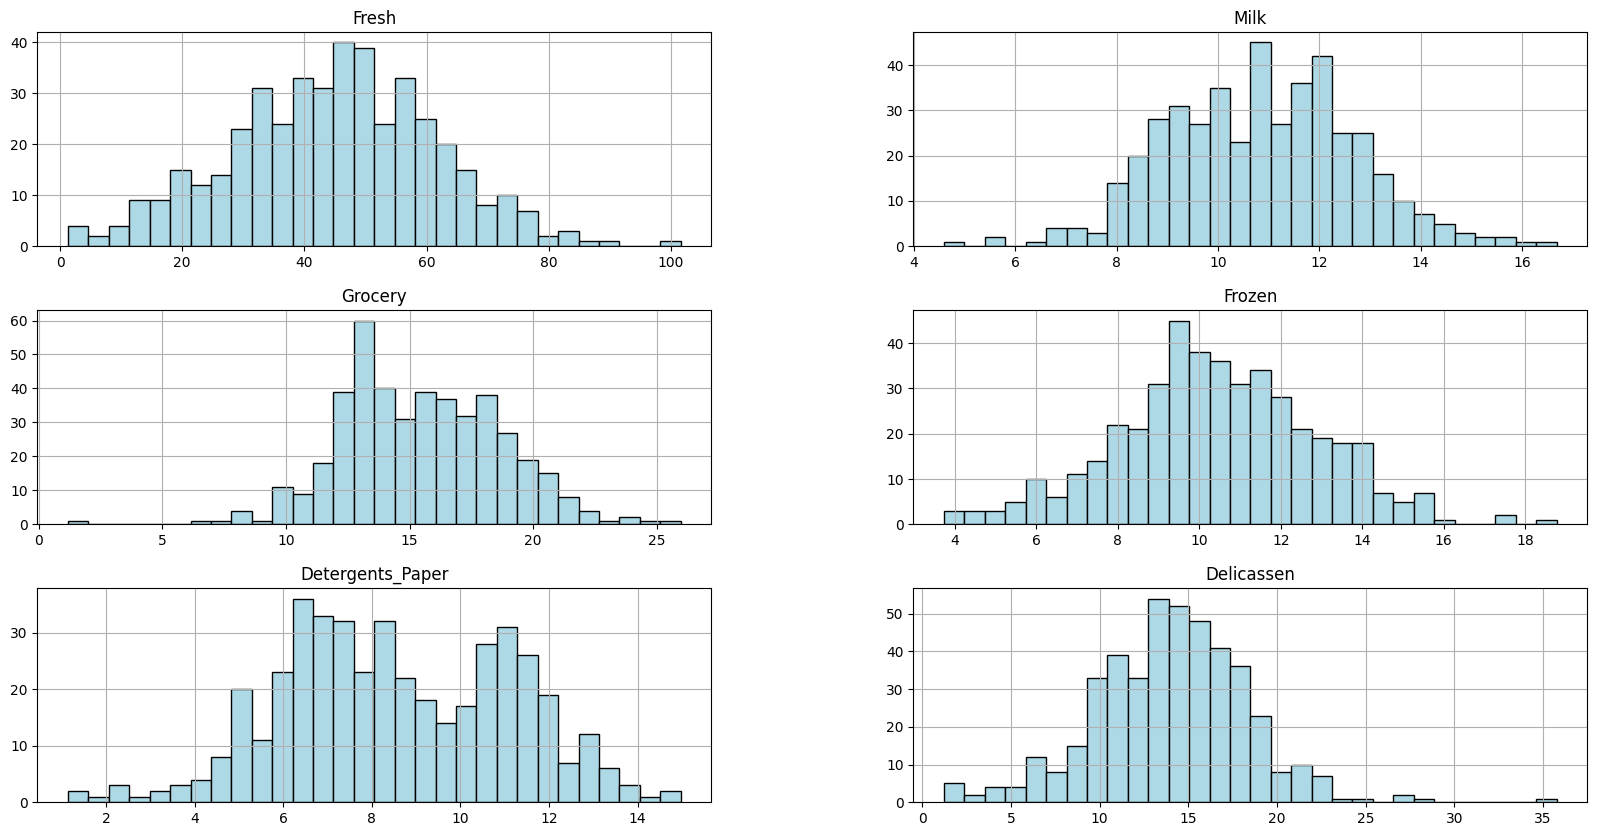

In [18]:
#Now the data resembles more the normal distribution

data.hist(figsize=(20,10),bins=30, color='lightblue', edgecolor='black')
plt.show()

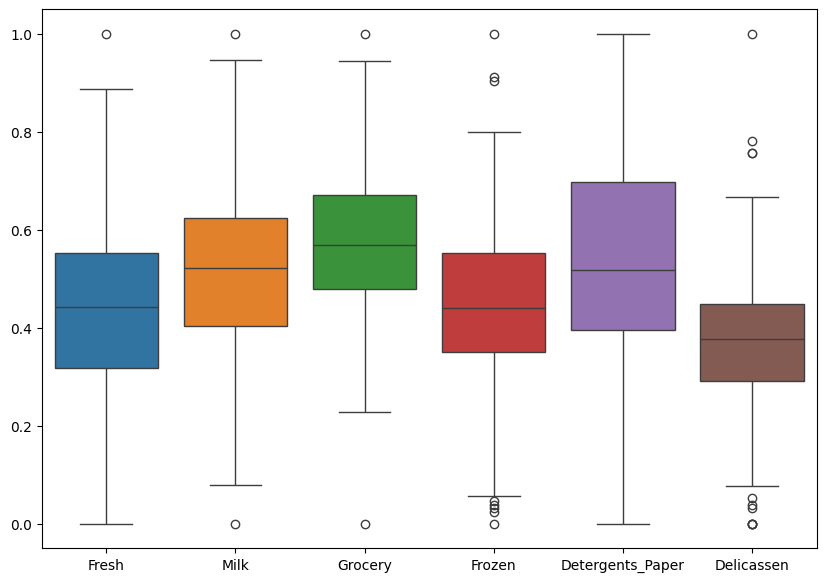

In [19]:
norm=data.iloc[:,2:] #Numerical data

scaler=MinMaxScaler()
columns=data.columns[2:]
norm=scaler.fit_transform(data.iloc[:,2:]) #Only numeric variables
norm=pd.DataFrame(norm, columns=columns)

plt.figure(figsize=(10,7))
sns.boxplot(data=norm)
plt.show()

In [20]:
for i in norm.columns:
    iqr=np.percentile(norm[i], 75)-np.percentile(norm[i], 25)
    per75=np.percentile(norm[i], 75)
    per25=np.percentile(norm[i], 25)
    norm[i]=np.where(norm[i]>per75+1.5*iqr, per75+1.5*iqr,norm[i] )
    norm[i]=np.where(norm[i]<per25-1.5*iqr, per25-1.5*iqr,norm[i] )

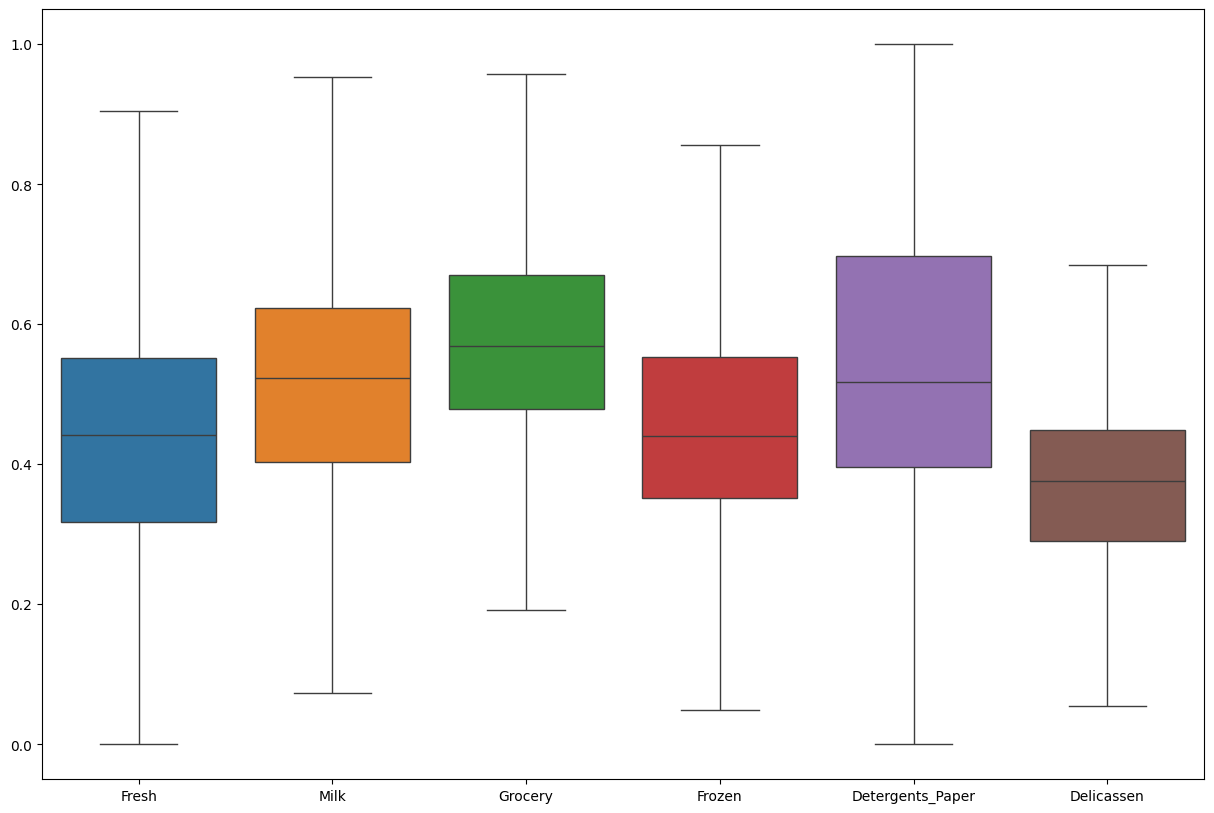

In [21]:
#Now we don´t have outliers

plt.figure(figsize=(15,10))
sns.boxplot(data=norm)
plt.show()

In [22]:
#Let´s also check for normality of the numeric variables now. However it is not a required assumptions
#of KMeans but can produce better results. Shapiro Wilks test may be employed.
#The null hypothesis is that the data is normal.



normality=pd.DataFrame(index=['p-value', 'test-statistic'])
for i in norm.columns:
    normality[i]=shapiro(norm[i])

normality.T

,p-value,test-statistic
Fresh,0.997203,0.662973
Milk,0.996521,0.459628
Grocery,0.992466,0.025729
Frozen,0.995659,0.264288
Detergents_Paper,0.985208,0.000185
Delicassen,0.992554,0.027443


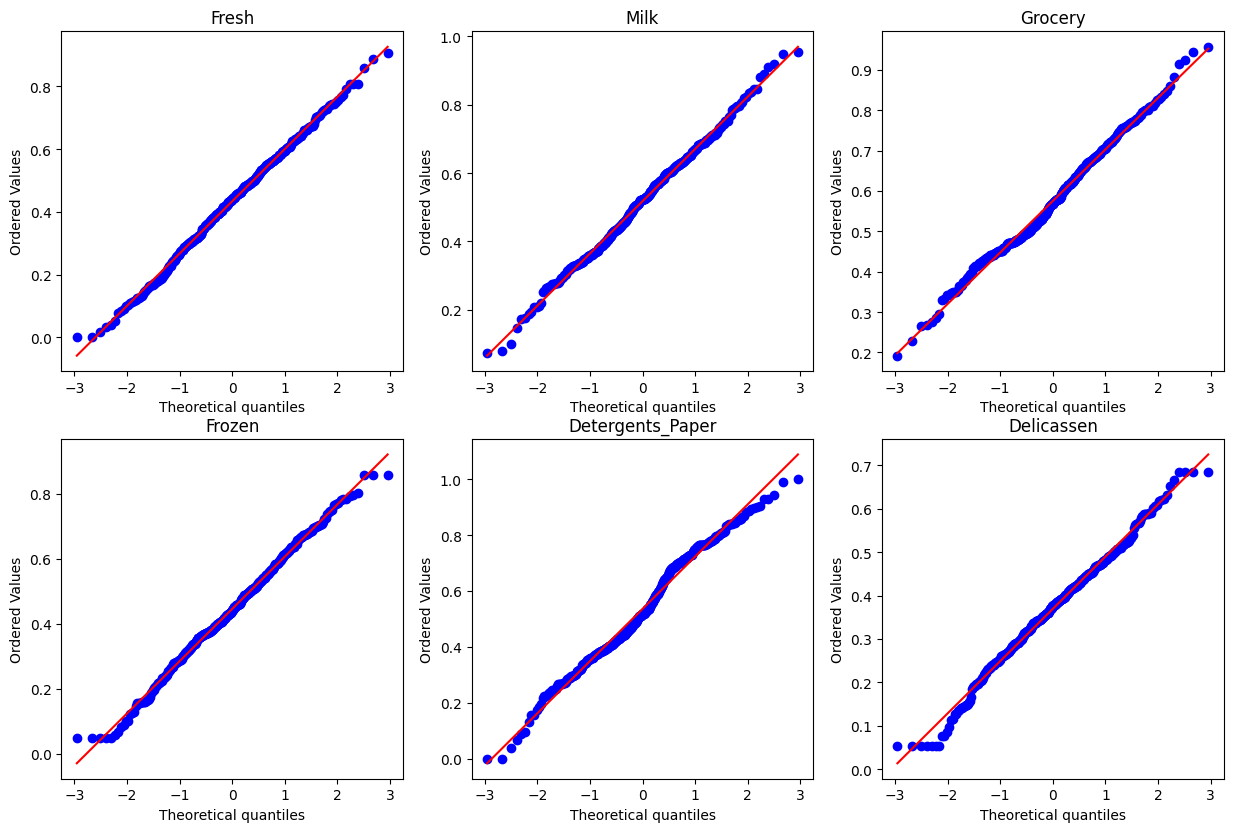

In [23]:
#We can also plot the normality via que quantile quantile plots from scipy statistical library.

plt.figure(figsize=(15,15))
for i,var in enumerate(norm.columns):
    plt.subplot(3,3,i+1)
    probplot(norm[var], plot=plt)
    plt.title(f'{var}')
plt.show()

In [24]:
data=pd.get_dummies(data=df, columns= ['Region','Channel'], drop_first=True)

#Uniting our categorical dummified variables with numerical normalized data.

data.iloc[:,:6]=norm

## Modelling and Analysis

In [25]:
elbow_results=[]
for i in range(2,10):
    kmeans=KMeans(init='k-means++' , n_clusters=i, random_state=0)
    results=cross_validate(kmeans, data, cv=5)
    elbow_results.append(results['test_score'].mean()*-1)

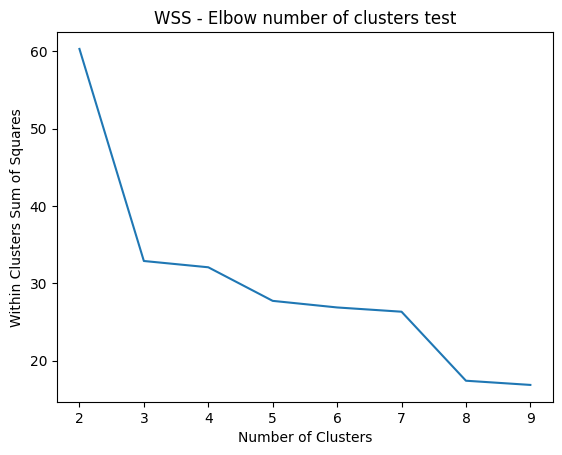

In [26]:

plt.plot(range(2,len(elbow_results)+2) , elbow_results)
plt.title('WSS - Elbow number of clusters test')
plt.xlabel('Number of Clusters')
plt.ylabel('Within Clusters Sum of Squares')
plt.show()

In [27]:
kmeans=KMeans(init='k-means++' , n_clusters=3, random_state=0)

cluster_model=kmeans.fit(data)


df['clusters']=cluster_model.predict(data).astype('str')

data['clusters']=df['clusters']

In [28]:
pca=PCA(n_components=len(data.columns)-1)

pca.fit(data.iloc[:,:-1])

pca.explained_variance_ratio_

array([0.43475419, 0.3627994 , 0.06304534, 0.05522108, 0.0336834 ,
       0.02176789, 0.01480611, 0.00983244, 0.00409015])

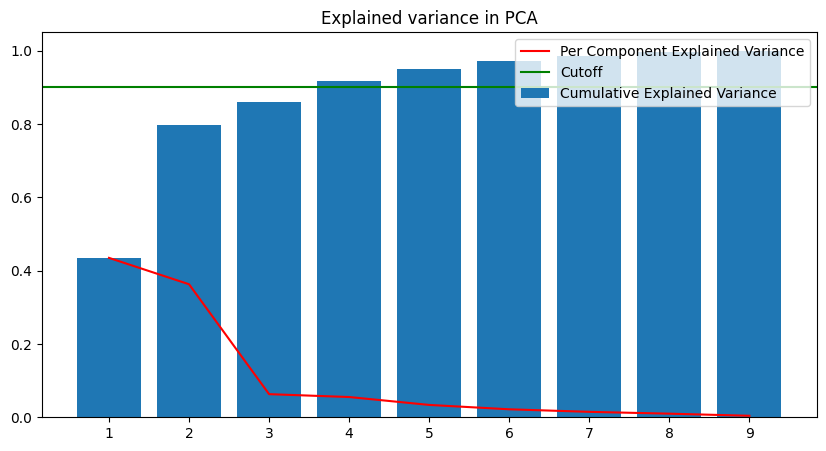

In [29]:
plt.figure(figsize=(10,5))
plt.plot(range(1,10),pca.explained_variance_ratio_, c='red', label='Per Component Explained Variance')
plt.bar(range(1,10), height=np.cumsum(pca.explained_variance_ratio_), label='Cumulative Explained Variance')
plt.axhline(y=0.9, c='g', label='Cutoff')
plt.title('Explained variance in PCA')
plt.xticks(range(1,10))
plt.legend(loc=1)
plt.show()

We can see that 90% of explained variability reached when we use 4 components. Therefore we will implement dimensionality reduction to 4 components

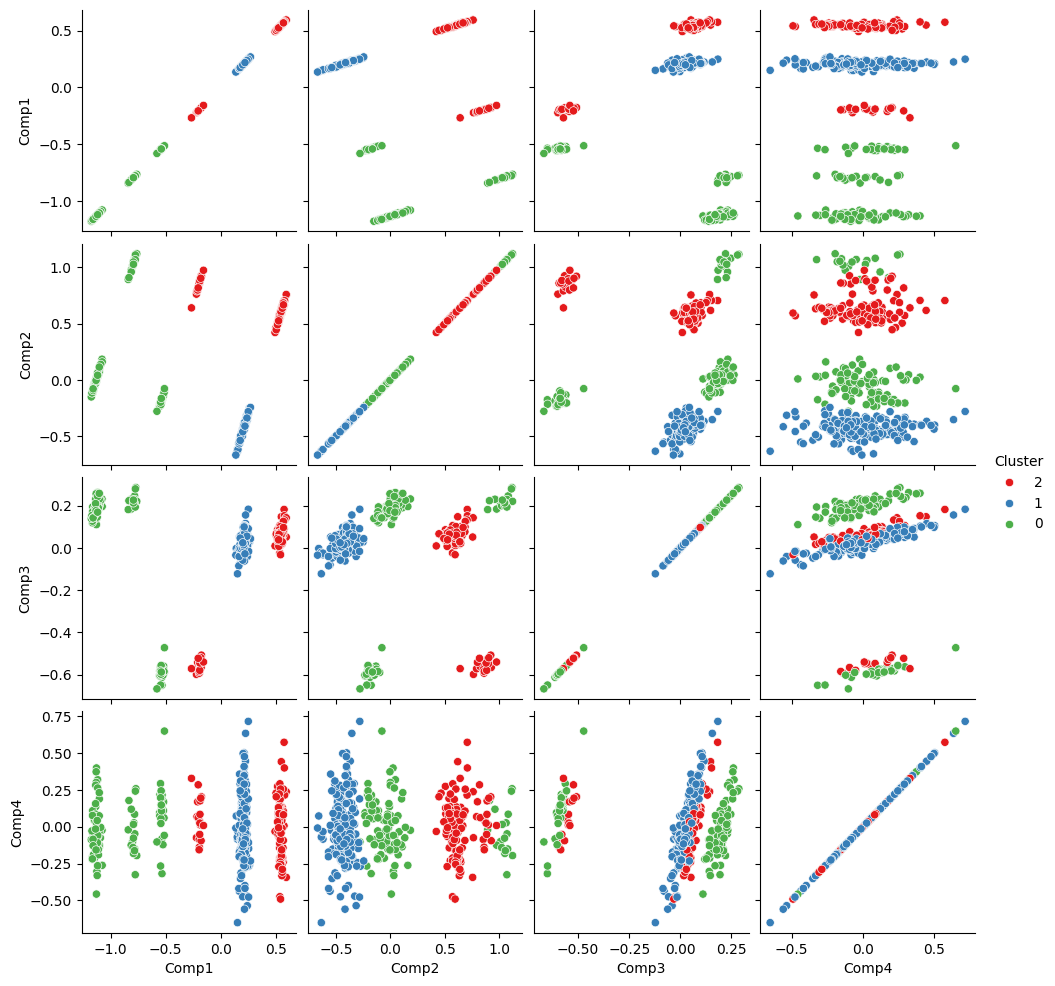

In [30]:
pca=PCA(n_components=4)
reduced=pca.fit_transform(data.iloc[:,:-1])

reduced=pd.DataFrame(np.column_stack([reduced, data.clusters]), columns=['Comp1','Comp2','Comp3','Comp4','Cluster'])

sns.pairplot(reduced, hue='Cluster', diag_kind=None, vars=reduced.columns[0:-1], palette='Set1')
plt.show()

It´s difficult to grasp the clusters like that. Let´s perform a component reduction to two variables.

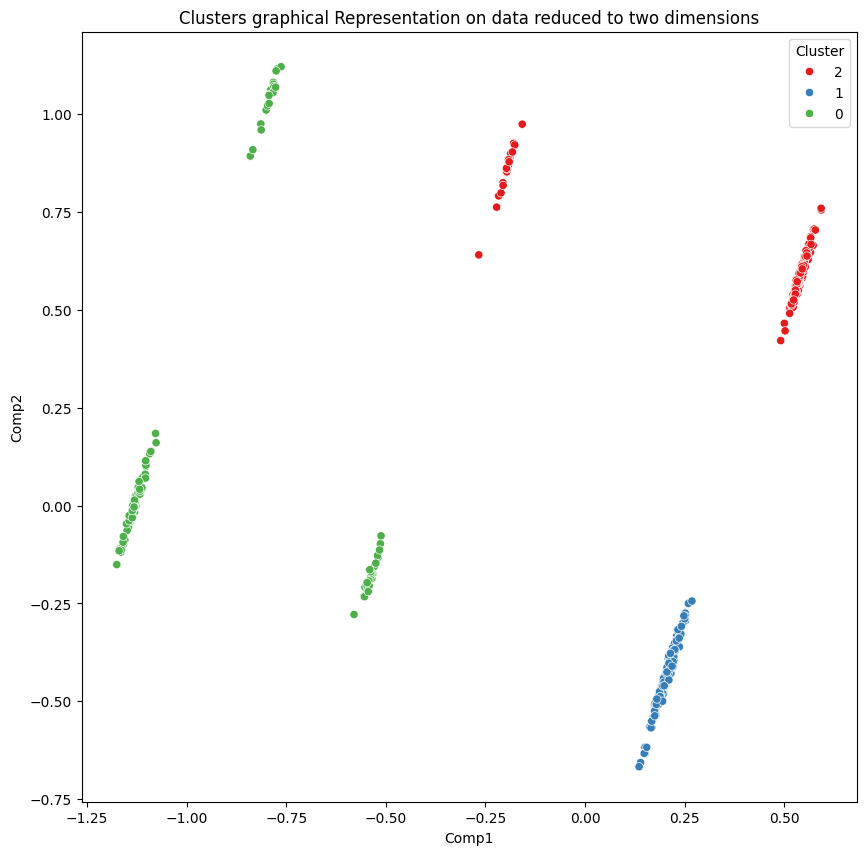

In [31]:
pca=PCA(n_components=2)
reduced=pca.fit_transform(data.iloc[:,:-1])
reduced=pd.DataFrame(np.column_stack([reduced, df.clusters]), columns=['Comp1','Comp2','Cluster'])

plt.figure(figsize=(10,10))
sns.scatterplot(data=reduced, hue='Cluster', x='Comp1',y='Comp2', palette='Set1')
plt.title('Clusters graphical Representation on data reduced to two dimensions',  fontsize=12)
plt.show()

<Figure size 1000x1000 with 0 Axes>

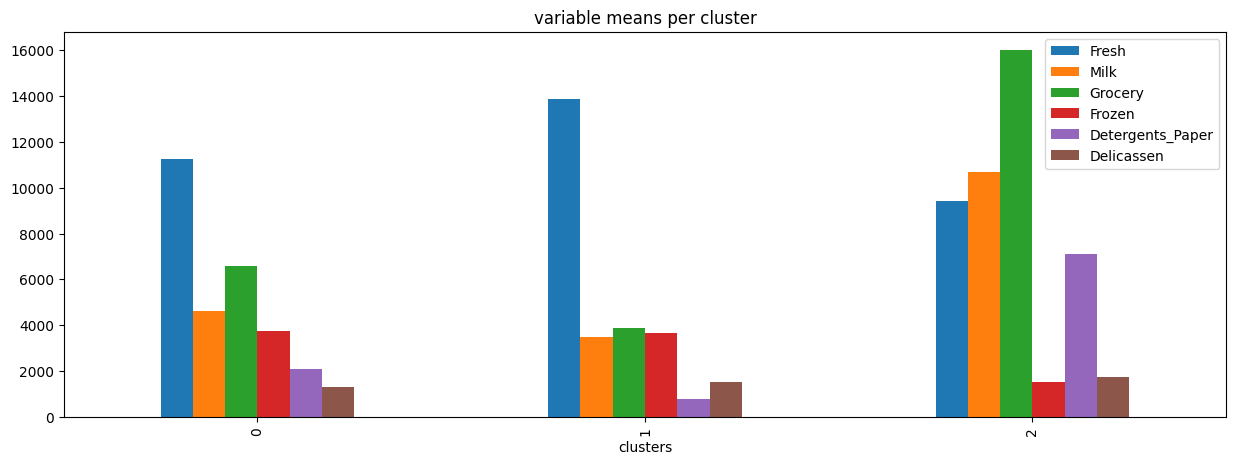

In [32]:
means=df.iloc[:,2:].groupby('clusters').mean()


plt.figure(figsize=(10,10))
means.groupby('clusters').mean().plot(kind='bar', figsize=(15,5))
plt.title('variable means per cluster')
plt.show()

In [33]:
hierarchy=AgglomerativeClustering(n_clusters=6, metric='euclidean', linkage='ward', compute_distances=True)

df['Hierarchical_clusters']=hierarchy.fit_predict(data)

In [34]:
reduced2=pd.DataFrame(np.column_stack([reduced, df['Hierarchical_clusters']]), columns=['Comp1','Comp2','Cluster_K_Means','Hierarchical_Clusters'])

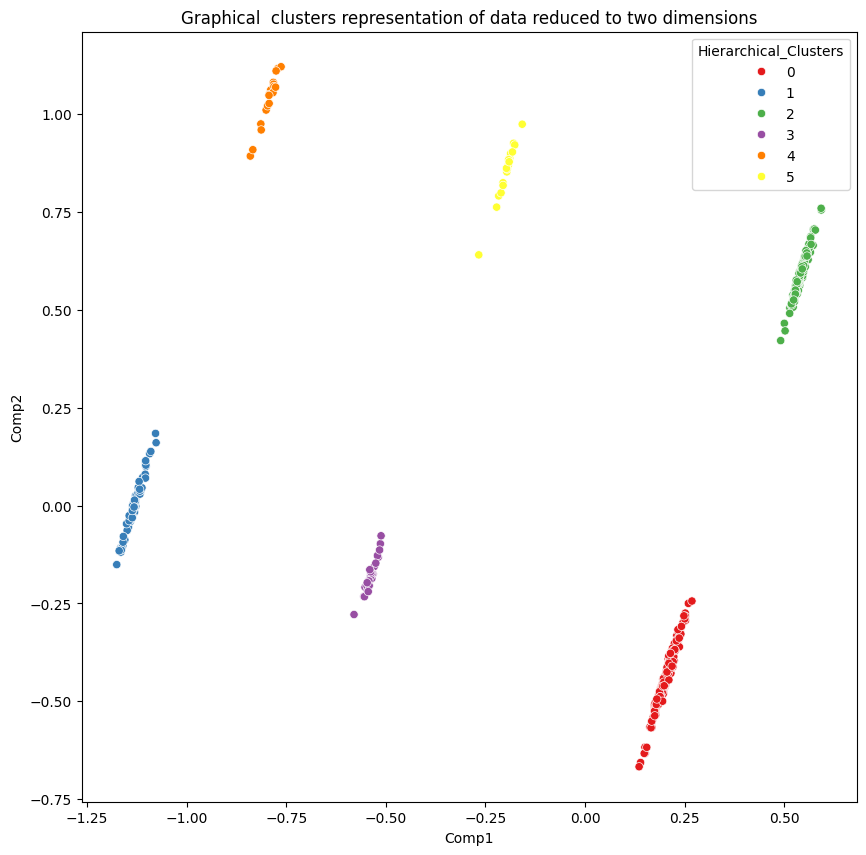

In [35]:
plt.figure(figsize=(10,10))
sns.scatterplot(data=reduced2, hue='Hierarchical_Clusters', x='Comp1',y='Comp2', palette='Set1')
plt.title('Graphical  clusters representation of data reduced to two dimensions',  fontsize=12)
plt.show()

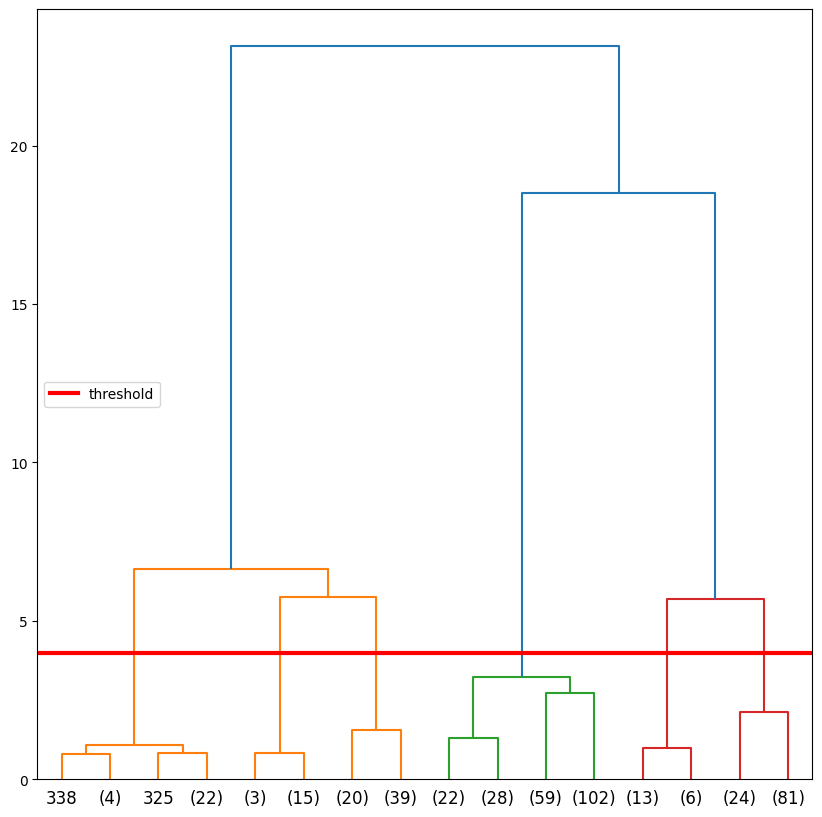

In [36]:


plt.figure(figsize=(10,10))
dendrogram(linkage(data ,method='ward'), truncate_mode='level', p=3 )
plt.axhline(y=4, label='threshold', color='red', lw=3)
plt.title='Dendrogram'
plt.legend(loc=6)
plt.show()

In [37]:
#Number of observations per Cluster
print(reduced2.Hierarchical_Clusters.value_counts())

Hierarchical_Clusters
0    211
2    105
1     59
3     28
5     19
4     18
Name: count, dtype: int64
